# ICE 3: Computer Vision

Identifying the health of plants is a critical component of maximizing yield in agriculture. Oftentimes, ailments present in the leaves of a small number of plants and so effective early identification of these issues could help prevent the spread. In this assignment, we will train a model to predict the health of a plant based off of its leaves.

### Goal:
Utilizing the dataset at the following link, train a model to detect specific types of diseases (based off of leaf imagery) for one (or more) of the available fruits.

Dataset link: https://data.mendeley.com/datasets/tywbtsjrjv/1

Tasks:
1. Train a CNN from the ground up (i.e. no pretrained models) to predict the category of health status for one or more plants.
2. Leverage an appropriate pretrained model to predict the category of health status for one or more plants. Feel free to use any model of your choice (e.g. ResNet-50 with ImageNet weights)

In [1]:
!wget https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/b4e3a32f-c0bd-4060-81e9-6144231f2520/file_downloaded

--2023-10-11 21:39:44--  https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/b4e3a32f-c0bd-4060-81e9-6144231f2520/file_downloaded
Resolving data.mendeley.com (data.mendeley.com)... 162.159.133.86, 162.159.130.86
Connecting to data.mendeley.com (data.mendeley.com)|162.159.133.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/349ac012-2948-4172-bbba-3bf8f76596fd [following]
--2023-10-11 21:39:44--  https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/349ac012-2948-4172-bbba-3bf8f76596fd
Resolving prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)... 52.218.60.48, 52.218.45.82, 52.218.40.200, ...
Connecting to prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)|52.218.60.48|:44

In [2]:
!unzip file_downloaded

Streaming output truncated to the last 5000 lines.
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (132).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1320).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1321).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1322).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1323).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1324).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1325).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1326).JPG  
  infl

In [3]:
import os
len(os.listdir('/content/Plant_leave_diseases_dataset_with_augmentation/Corn___Common_rust'))

1192

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import Model
from keras.layers import Dropout
import tensorflow as tf
import numpy as np


In [5]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define directories
source_dirs = ['Corn___healthy', 'Corn___Northern_Leaf_Blight',
               'Corn___Common_rust', 'Corn___Cercospora_leaf_spot Gray_leaf_spot']

train_dir = '/content/Corn_train_val_test/train'
test_dir = '/content/Corn_train_val_test/test'
val_dir = '/content/Corn_train_val_test/val'

# Create train, test, and validation directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Function to split and copy files
def split_and_copy_files(source_dir, train_dir, test_dir, val_dir, test_size=0.2, val_size=0.1):
    files = [f for f in os.listdir(source_dir) if os.path.isfile(os.path.join(source_dir, f))]

    # Split data
    train_files, temp_files = train_test_split(files, test_size=(test_size + val_size), random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=(test_size / (test_size + val_size)), random_state=42)

    # Copy files to respective directories
    for f in train_files:
        shutil.copy(os.path.join(source_dir, f), os.path.join(train_dir, f))
    for f in test_files:
        shutil.copy(os.path.join(source_dir, f), os.path.join(test_dir, f))
    for f in val_files:
        shutil.copy(os.path.join(source_dir, f), os.path.join(val_dir, f))

# Iterate through each source directory and split files
for source in source_dirs:
    src_path = os.path.join('/content/Plant_leave_diseases_dataset_with_augmentation', source)  # Replace with the path to your folders
    train_dst = os.path.join(train_dir, source)
    test_dst = os.path.join(test_dir, source)
    val_dst = os.path.join(val_dir, source)

    # Create destination directories
    os.makedirs(train_dst, exist_ok=True)
    os.makedirs(test_dst, exist_ok=True)
    os.makedirs(val_dst, exist_ok=True)

    # Split and copy files
    split_and_copy_files(src_path, train_dst, test_dst, val_dst)

In [6]:
batch_size = 32
img_size = (224, 224)

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    target_size=img_size,
                                                    shuffle=False)

val_generator = val_datagen.flow_from_directory(val_dir,
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                target_size=img_size,
                                                shuffle=False)

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  target_size=img_size,
                                                  shuffle=False)

Found 3045 images belonging to 4 classes.
Found 435 images belonging to 4 classes.
Found 874 images belonging to 4 classes.


###CNN From Ground Up!

In [8]:
model2 = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(4, activation='softmax')  #4 is number of categories for corn
])

In [9]:
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model2.summary()

In [21]:
history2 = model2.fit(train_generator, epochs=33, batch_size = 32, validation_data=val_generator)

Epoch 1/5
96/96 [==============================] - 7s 76ms/step - loss: 0.5173 - accuracy: 0.7373 - val_loss: 0.6830 - val_accuracy: 0.7954
Epoch 2/5
96/96 [==============================] - 7s 73ms/step - loss: 0.4999 - accuracy: 0.7770 - val_loss: 0.6851 - val_accuracy: 0.7195
Epoch 3/5
96/96 [==============================] - 7s 70ms/step - loss: 0.5363 - accuracy: 0.7281 - val_loss: 0.6632 - val_accuracy: 0.7356
Epoch 4/5
96/96 [==============================] - 7s 75ms/step - loss: 0.4854 - accuracy: 0.7711 - val_loss: 0.6396 - val_accuracy: 0.7333
Epoch 5/5
96/96 [==============================] - 6s 66ms/step - loss: 0.4549 - accuracy: 0.7915 - val_loss: 0.9922 - val_accuracy: 0.7793


In [22]:
training_accuracies = history2.history['accuracy']
validation_accuracies = history2.history['val_accuracy']

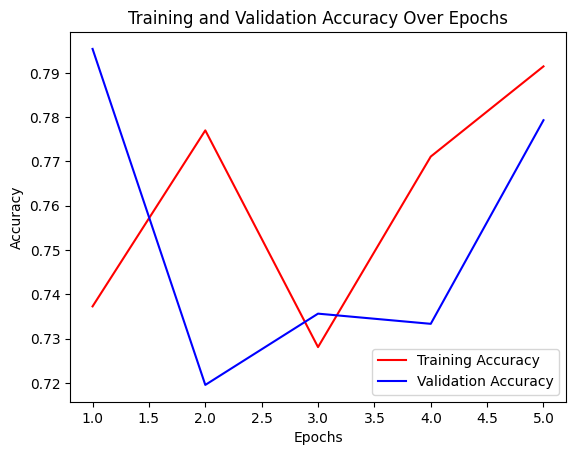

In [23]:
import matplotlib.pyplot as plt

epochs = range(1, len(training_accuracies) + 1)

# Plotting
plt.plot(epochs, training_accuracies, 'r-', label='Training Accuracy')
plt.plot(epochs, validation_accuracies, 'b-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

This is Epochs 28 -> 33

###Test CNN from Ground Up

In [24]:
loss, accuracy = model2.evaluate(test_generator)
print(f"Accuracy: {accuracy*100:.2f}%")

# model2.save("/content/drive/MyDrive/CNN_Ground_UP_Model")

28/28 [==============================] - 2s 65ms/step - loss: 0.4943 - accuracy: 0.7746
Accuracy: 77.46%


###Clears Any Backend Session

In [ ]:
from tensorflow.keras import backend as K
K.clear_session()

###ResNet50

In [13]:
base_model = ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze layers
for layer in base_model.layers:
    layer.trainable = False

train_features = base_model.predict(train_generator)
val_features = base_model.predict(val_generator)
test_features = base_model.predict(test_generator)

28/28 [==============================] - 4s 131ms/step


In [14]:
#Flatten
train_features_flat = np.reshape(train_features, (train_features.shape[0], -1))
val_features_flat = np.reshape(val_features, (val_features.shape[0], -1))
test_features_flat = np.reshape(test_features, (test_features.shape[0], -1))

In [15]:
model = Model()

x = layers.Input(shape=(train_features_flat.shape[1],))
y = layers.Dense(512, activation='relu')(x)
# y = layers.Dropout(0.2)(y)
y = layers.Dense(256, activation='relu')(y)
y = layers.Dropout(0.2)(y)


# Adjust the number of units in the final dense layer to match the number of classes
num_classes = len(train_generator.class_indices)
y = layers.Dense(num_classes, activation='softmax')(y)

model = Model(x, y)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) #sparse is handling the variable sizes

In [16]:
# Train
history = model.fit(train_features_flat, train_generator.labels,
          epochs=34, batch_size = 32,
          validation_data=(val_features_flat, val_generator.labels))

Epoch 1/34
96/96 [==============================] - 4s 29ms/step - loss: 2.2476 - accuracy: 0.4598 - val_loss: 1.4520 - val_accuracy: 0.6253
Epoch 2/34
96/96 [==============================] - 2s 21ms/step - loss: 0.8825 - accuracy: 0.6273 - val_loss: 0.8913 - val_accuracy: 0.5678
Epoch 3/34
96/96 [==============================] - 2s 20ms/step - loss: 0.6759 - accuracy: 0.6913 - val_loss: 0.6261 - val_accuracy: 0.7448
Epoch 4/34
96/96 [==============================] - 2s 20ms/step - loss: 0.5904 - accuracy: 0.7287 - val_loss: 0.7489 - val_accuracy: 0.6805
Epoch 5/34
96/96 [==============================] - 2s 20ms/step - loss: 0.5939 - accuracy: 0.7245 - val_loss: 0.9119 - val_accuracy: 0.6299
Epoch 6/34
96/96 [==============================] - 2s 22ms/step - loss: 0.6126 - accuracy: 0.7264 - val_loss: 0.5298 - val_accuracy: 0.7586
Epoch 7/34
96/96 [==============================] - 2s 25ms/step - loss: 0.4990 - accuracy: 0.7882 - val_loss: 0.7010 - val_accuracy: 0.7034
Epoch 8/34
96

In [17]:
training_accuracies = history.history['accuracy']
validation_accuracies = history.history['val_accuracy']

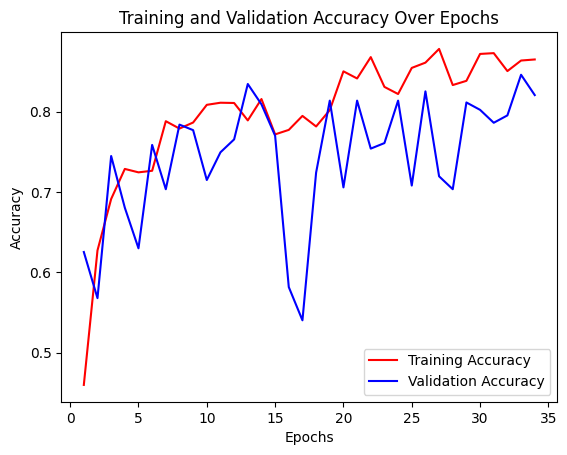

In [18]:
import matplotlib.pyplot as plt

epochs = range(1, len(training_accuracies) + 1)

# Plotting
plt.plot(epochs, training_accuracies, 'r-', label='Training Accuracy')
plt.plot(epochs, validation_accuracies, 'b-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

###Test ResNet50 Transfer

In [25]:
test_loss, test_accuracy = model.evaluate(test_features_flat, test_generator.labels)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

28/28 [==============================] - 0s 10ms/step - loss: 0.4251 - accuracy: 0.8467
Test Loss: 0.4250658452510834, Test Accuracy: 0.8466818928718567


In [26]:
print(f"Accuracy: {test_accuracy*100:.2f}%")

Accuracy: 84.67%
